In [1]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


# Maxwell Bloch equations

In [3]:
def density_der(p):
    gamma = 0.01
    Omega = 2*np.pi*0.1
    delta = 0.1
    pdot = np.array([0+0*1j,0+0*1j,0+0*1j,0+0*1j])
    pdot[0] = (-gamma*p[0]) + 0.5j*(Omega*(p[2] - p[1]))
    pdot[1] = -(-1j*delta + gamma/2)*p[1] - 0.5j*(Omega*(p[0] - p[3]))
    pdot[2] = -(1j*delta + gamma/2)*p[2] + 0.5j*(Omega*(p[0] - p[3]))
    pdot[3] = (gamma*p[0]) - 0.5j*(Omega*(p[2] - p[1]))
    return pdot

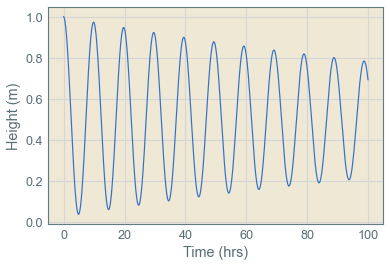

In [4]:
t = np.linspace(0,100,10000)
step_size = t[1]-t[0]
p0 = np.array([1+0*1j,0+0*1j,0+0*1j,0+0*1j])
a = 0
solution = [abs(p0[a])]
for j in range(1,len(t)):
    add = density_der(p0)
    for i in range(4):
        p0[i] += add[i]*step_size 
    solution.append(abs(p0[a]))
plt.plot(t,np.absolute(solution))
plt.xlabel('Time (hrs)')
plt.ylabel('Height (m)')
plt.show()

# Jaynes Cumming Hamiltonian

In [5]:
def jch(N,wc,wa,gamma,Omega,kappa):
    #Operators of the system
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    H_field = wc*a*a.dag()
    H_atom = wa*sm.dag()*sm
    H_int = Omega*(a + a.dag())*(sm + sm.dag())
    H = H_field + H_atom + H_int
    
    #Running it
    psi0 = tensor(fock(N,1), fock(2,0))
    t = np.linspace(0,10*np.pi/Omega,10000)
    c_op_list = [np.sqrt(gamma)*sm, np.sqrt(kappa)*a] #Collapse operator
    output = mesolve(H, psi0, t, c_op_list, [a.dag()*a, sm.dag()*sm])
    return output

In [6]:
#Set parameter values
gamma = 3*1e6
Omega = 100*1e6
wc = 100*1e7
delta = 0
wa = wc + delta
N = 16
kappa = np.array([1,10,50,200,300])*1e6
t = np.linspace(0,10*np.pi/Omega,10000)

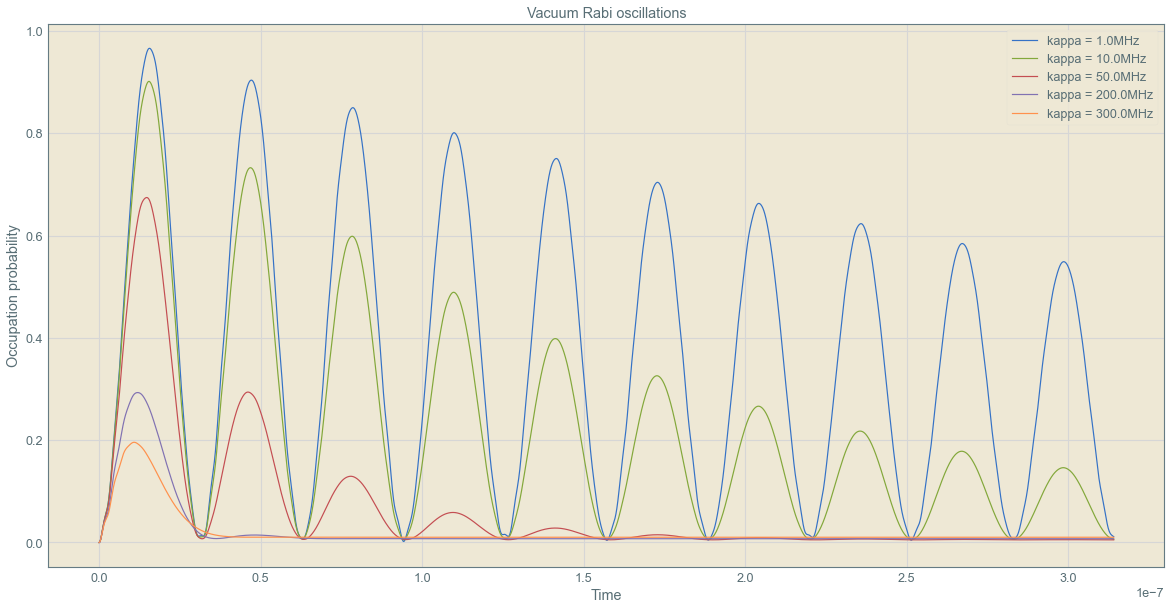

In [18]:
#Graphs\
colors = ['coral','aqua','palegreen','ivory','magenta']
outputs = []
for i in range(len(kappa)):
    output = jch(N,wc,wa,gamma,Omega,kappa[i])
    outputs.append(output)
    plt.plot(t, output.expect[1], label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

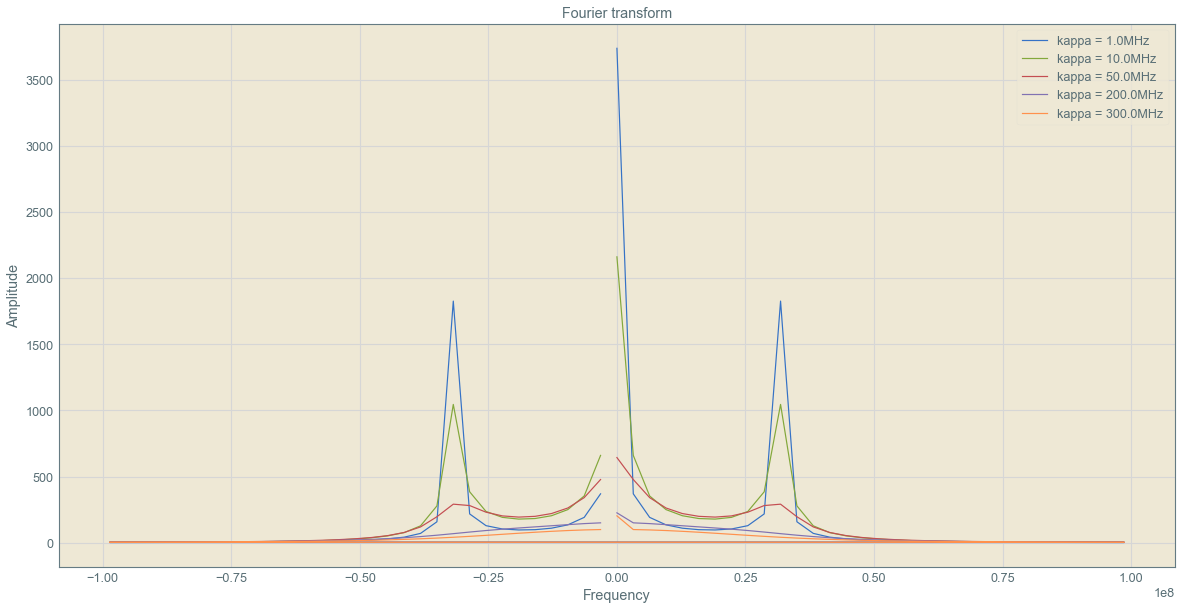

In [19]:
fft_out = []
for i in range(len(outputs)):
    yf = np.absolute(np.fft.fft(outputs[i].expect[1]))
    xf = np.fft.fftfreq(len(t), t[1] - t[0])
    y = []
    x = []
    for j in range(len(xf)):
        if abs(xf[j]) < 1e8:
            x.append(xf[j])
            y.append(yf[j])
    fft_out.append(yf)
    plt.plot(x, y, label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier transform')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

In [9]:
def jch_coh(N,wc,wa,gamma,Omega,kappa,cyc=10,al=1):
    #Operators of the system
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    H_field = wc*a*a.dag()
    H_atom = wa*sm.dag()*sm
    H_int = Omega*(a + a.dag())*(sm + sm.dag())
    H = H_field + H_atom + H_int
    
    #Running it
    psi0 = tensor(coherent(N = N,alpha = al), fock(2,0))
    t = np.linspace(0,cyc*np.pi/Omega,1000*cyc)
    c_op_list = [np.sqrt(gamma)*sm, np.sqrt(kappa)*a] #Collapse operator
    output = mesolve(H, psi0, t, c_op_list, [a.dag()*a, sm.dag()*sm])
    return output

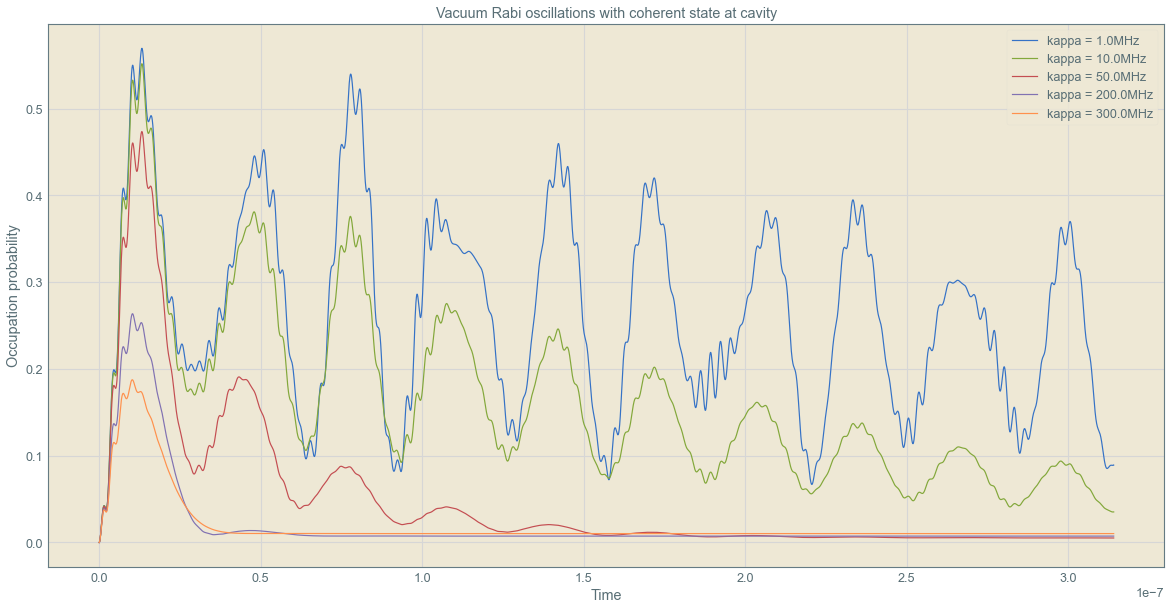

In [20]:
for i in range(len(kappa)):
    output = jch_coh(N,wc,wa,gamma,Omega,kappa[i])
    plt.plot(t, output.expect[1], label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations with coherent state at cavity')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

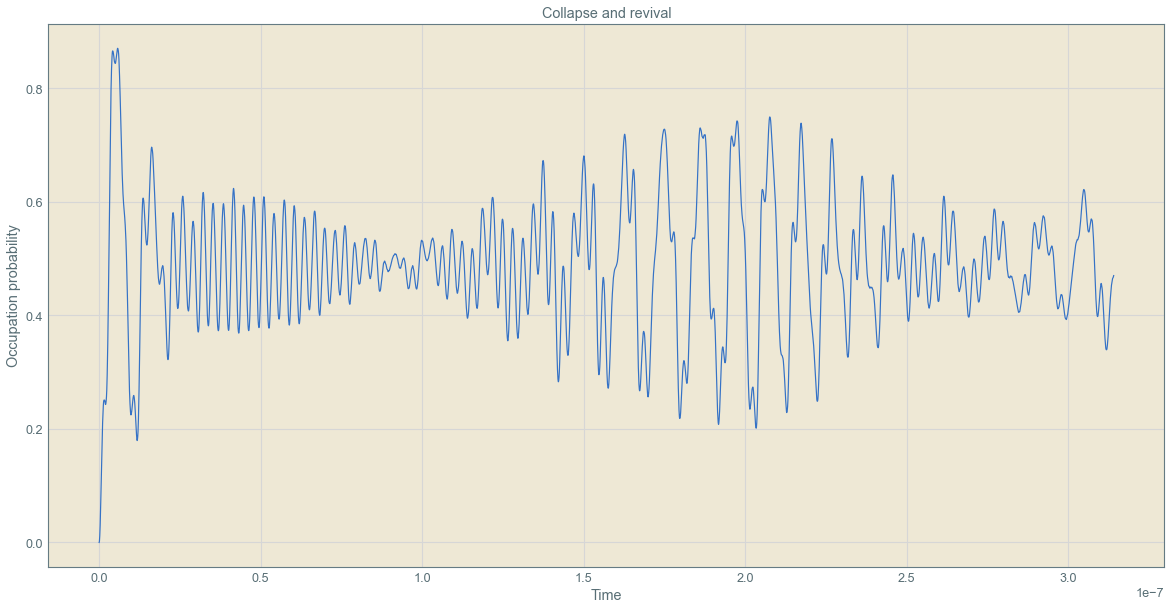

In [11]:
#Collapse and revival
output = jch_coh(N,wc,wa,1e3,Omega,1e3,10,3)
plt.plot(t, output.expect[1])
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Collapse and revival')
plt.gcf().set_size_inches(20,10)
plt.axis()
plt.show()